# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: Optimizers comparison
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_10932\3092398611.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

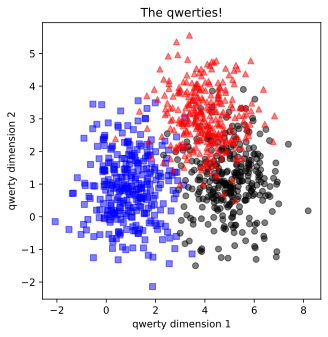

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


# The model

In [12]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo, learning_rate):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=learning_rate)

  return net,lossfun,optimizer


In [13]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('RMSprop', 0.01)[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

# A function that trains the model

In [14]:
def funtion2trainTheModel(optimizerType, learning_rate):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType, learning_rate)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Now for the optimizer comparison

In [16]:
# run the model for one optimizer
optimizerType = 'Adam'
trainAcc,testAcc,losses,net = funtion2trainTheModel(optimizerType, 0.01)

In [33]:
# now run through all of them
learning_rates = np.logspace(np.log10(10**-4), np.log10(10**-1), 20)
repeats = 1
optimizers = ['SGD','RMSprop','Adam']

test_accuracy = {
  "SGD": np.zeros(learning_rates.size),
  "RMSprop": np.zeros(learning_rates.size),
  "Adam": np.zeros(learning_rates.size)
}

for opto in optimizers:
  for lr_i, lr in enumerate(learning_rates):
    print(f"Testing {opto} with lr: {lr}...")
    for rep in range(repeats):
      trainAcc,testAcc, losses, net = funtion2trainTheModel(opto, lr)

      final_test_accuracy = np.mean(testAcc[-10:])
      test_accuracy[opto][lr_i] += final_test_accuracy / repeats

print("Finished!")

Testing SGD with lr: 0.0001...
Testing SGD with lr: 0.0001438449888287663...
Testing SGD with lr: 0.00020691380811147902...
Testing SGD with lr: 0.00029763514416313193...
Testing SGD with lr: 0.00042813323987193956...
Testing SGD with lr: 0.0006158482110660267...
Testing SGD with lr: 0.0008858667904100823...
Testing SGD with lr: 0.0012742749857031334...
Testing SGD with lr: 0.0018329807108324356...
Testing SGD with lr: 0.0026366508987303583...
Testing SGD with lr: 0.00379269019073225...
Testing SGD with lr: 0.005455594781168515...
Testing SGD with lr: 0.007847599703514606...
Testing SGD with lr: 0.011288378916846883...
Testing SGD with lr: 0.01623776739188721...
Testing SGD with lr: 0.023357214690901212...
Testing SGD with lr: 0.03359818286283781...
Testing SGD with lr: 0.04832930238571752...
Testing SGD with lr: 0.06951927961775606...
Testing SGD with lr: 0.1...
Testing RMSprop with lr: 0.0001...
Testing RMSprop with lr: 0.0001438449888287663...
Testing RMSprop with lr: 0.000206913808

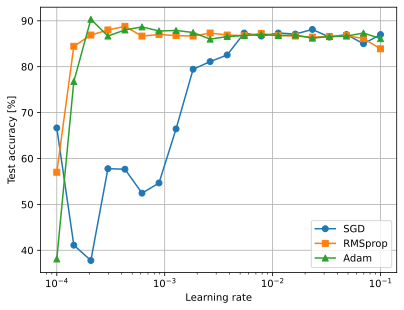

In [34]:
plt.figure()

markers = ['o', 's', '^']
for idx, opto in enumerate(optimizers):
  plt.plot(learning_rates, test_accuracy[opto], label=opto, marker=markers[idx])
plt.legend()
plt.xscale('log')
plt.xlabel("Learning rate")
plt.ylabel("Test accuracy [%]")
plt.grid()

plt.show()